Split Thyloid.csv into Train and Test datasets

---



In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('Thyloid.csv')
print(data.shape)

# Splitting the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Storing the labels separately
train_label = train_data.iloc[:, -1]
test_label = test_data.iloc[:, -1]

# Removing the last column from the data itself
train_X = train_data.iloc[:, :-1]
test_X = test_data.iloc[:, :-1]

# Converting to numpy
train = train_X.to_numpy()
test = test_X.to_numpy()

(574, 1882)


Apply PCA and KPCA models to transform the Test dataset


In [2]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

# Function to apply PCA and transform data
def apply_pca(train_data, test_data, n_components=0.95):
    pca = PCA(n_components=n_components)
    train_transformed = pca.fit_transform(train_data)
    test_transformed = pca.transform(test_data)
    return train_transformed, test_transformed, pca

# Apply PCA
train_pca, test_pca, pca_model = apply_pca(train, test)

# Function to apply KPCA and transform data
def apply_kpca(train_data, test_data, kernel='rbf', n_components=None, gamma=None, degree=3): # Set default degree to 3
    kpca = KernelPCA(n_components=n_components, kernel=kernel, gamma=gamma, degree=degree)
    train_transformed = kpca.fit_transform(train_data)
    test_transformed = kpca.transform(test_data)
    return train_transformed, test_transformed, kpca

# Apply KPCA with RBF kernel
train_kpca_rbf, test_kpca_rbf, kpca_rbf_model = apply_kpca(train, test, kernel='rbf', gamma=0.5)

# Apply KPCA with Polynomial kernel
train_kpca_poly, test_kpca_poly, kpca_poly_model = apply_kpca(train, test, kernel='poly') # No need to specify degree since default is now 3

# Apply KPCA with Linear kernel
train_kpca_linear, test_kpca_linear, kpca_linear_model = apply_kpca(train, test, kernel='linear')

# Ensure the dimensionality reduction is consistent
print(f'PCA Train shape: {train_pca.shape}, Test shape: {test_pca.shape}')
print(f'KPCA (RBF) Train shape: {train_kpca_rbf.shape}, Test shape: {test_kpca_rbf.shape}')
print(f'KPCA (Poly) Train shape: {train_kpca_poly.shape}, Test shape: {test_kpca_poly.shape}')
print(f'KPCA (Linear) Train shape: {train_kpca_linear.shape}, Test shape: {test_kpca_linear.shape}')

PCA Train shape: (459, 7), Test shape: (115, 7)
KPCA (RBF) Train shape: (459, 458), Test shape: (115, 458)
KPCA (Poly) Train shape: (459, 458), Test shape: (115, 458)
KPCA (Linear) Train shape: (459, 458), Test shape: (115, 458)


Calculate the covariance matrix of the dataset

In [3]:
# Function to compute the covariance matrix
def compute_covariance_matrix(data):
    mean_vec = np.mean(data, axis=0)
    covariance_matrix = (data - mean_vec).T.dot((data - mean_vec)) / (data.shape[0] - 1)
    return covariance_matrix

# Calculate the covariance matrix of the training dataset
cov_matrix = compute_covariance_matrix(train)
print(cov_matrix.shape)

(1881, 1881)


Identify the top 10 features with the highest covariance values

Top 10 features with highest covariance values: [   2  226  357 1880  195  200  305  352  189  285]


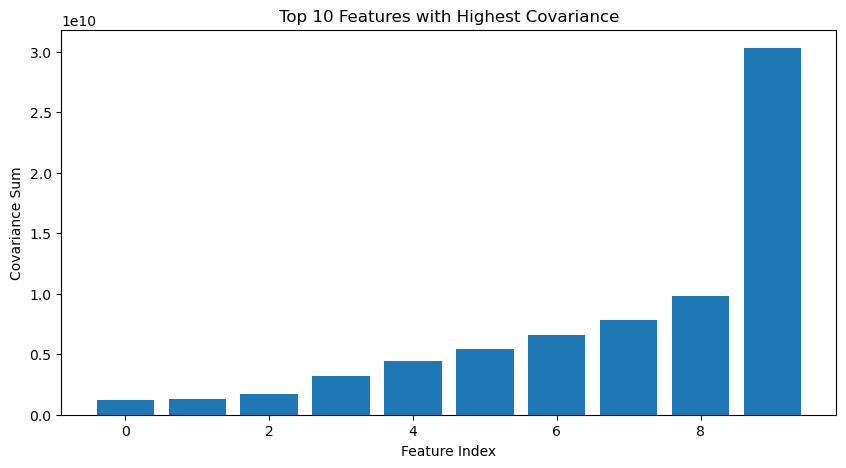

In [4]:
# Identify the top 10 features with the highest covariance values
cov_sum = np.sum(np.abs(cov_matrix), axis=0)
top_10_feature_indices = np.argsort(cov_sum)[-10:]

print(f'Top 10 features with highest covariance values: {top_10_feature_indices}')

# Extract top 10 features
train_top_10 = train[:, top_10_feature_indices]
test_top_10 = test[:, top_10_feature_indices]

# Visualizing the top 10 features
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(range(len(top_10_feature_indices)), cov_sum[top_10_feature_indices])
plt.xlabel('Feature Index')
plt.ylabel('Covariance Sum')
plt.title('Top 10 Features with Highest Covariance')
plt.show()

In [ ]:
from scipy.stats import multivariate_normal

# Function to calculate the mean and covariance for each class
def calculate_mean_covariance(X, y):
    classes = np.unique(y)
    mean_cov = {}
    for cls in classes:
        X_cls = X[y == cls]
        mean_cov[cls] = {
            'mean': np.mean(X_cls, axis=0),
            # Add a small regularization term to the diagonal to ensure positive definiteness
            'cov': np.cov(X_cls, rowvar=False) + 1e-6 * np.eye(X_cls.shape[1])
        }
    return mean_cov

# Function to predict using the Bayes classifier
def bayes_predict(X, mean_cov):
    classes = list(mean_cov.keys())
    predictions = []
    for x in X:
        probabilities = []
        for cls in classes:
            mean = mean_cov[cls]['mean']
            cov = mean_cov[cls]['cov']
            # Set allow_singular to True to handle potentially singular matrices
            prob = multivariate_normal.pdf(x, mean=mean, cov=cov, allow_singular=True)
            probabilities.append(prob)
        predictions.append(classes[np.argmax(probabilities)])
    return np.array(predictions)

# Train Bayes classifier
mean_cov = calculate_mean_covariance(train, train_label)

# Predict on test data
bayes_predictions = bayes_predict(test, mean_cov)

# Evaluate accuracy
bayes_accuracy = calculate_accuracy(test_label.to_numpy(), bayes_predictions)
print(f'Bayes Classifier Accuracy: {bayes_accuracy}')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to evaluate classifier
def evaluate_classifier(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='macro')
    recall = recall_score(y_test, predictions, average='macro')
    f1 = f1_score(y_test, predictions, average='macro')
    return accuracy, precision, recall, f1

# KNN
knn = KNeighborsClassifier()
knn_metrics = evaluate_classifier(knn, train, train_label, test, test_label)

# Naive Bayes
nb = GaussianNB()
nb_metrics = evaluate_classifier(nb, train, train_label, test, test_label)

# LDA
lda = LinearDiscriminantAnalysis()
lda_metrics = evaluate_classifier(lda, train, train_label, test, test_label)

# SVM
svm = SVC()
svm_metrics = evaluate_classifier(svm, train, train_label, test, test_label)

# Print metrics
print(f'KNN Metrics: {knn_metrics}')
print(f'Naive Bayes Metrics: {nb_metrics}')
print(f'LDA Metrics: {lda_metrics}')
print(f'SVM Metrics: {svm_metrics}')

In [ ]:
# Function to test and evaluate classifiers on different datasets
def test_classifiers_on_datasets(datasets, classifiers):
    results = {}
    for dataset_label, (X_train, X_test) in datasets.items():
        results[dataset_label] = {}
        for clf_label, clf in classifiers.items():
            if clf_label == 'Bayes (Scratch)':
                mean_cov = calculate_mean_covariance(X_train, train_label)
                predictions = bayes_predict(X_test, mean_cov)
                accuracy = calculate_accuracy(test_label.to_numpy(), predictions)
                precision = precision_score(test_label, predictions, average='macro')
                recall = recall_score(test_label, predictions, average='macro')
                f1 = f1_score(test_label, predictions, average='macro')
            else:
                accuracy, precision, recall, f1 = evaluate_classifier(clf, X_train, train_label, X_test, test_label)
            results[dataset_label][clf_label] = (accuracy, precision, recall, f1)
            print(f'{clf_label} on {dataset_label}: Accuracy={accuracy}, Precision={precision}, Recall={recall}, F1={f1}')
    return results

# Datasets to test
datasets = {
    'Whole Data': (train, test),
    'PCA': (train_pca, test_pca),
    'KPCA (RBF)': (train_kpca_rbf, test_kpca_rbf),
    'KPCA (Poly)': (train_kpca_poly, test_kpca_poly),
    'KPCA (Linear)': (train_kpca_linear, test_kpca_linear),
    'Top 10 Features': (train_top_10, test_top_10)
}

# Classifiers to test
classifiers = {
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'LDA': LinearDiscriminantAnalysis(),
    'SVM': SVC(),
    'Bayes (Scratch)': 'Bayes (Scratch)'
}

# Test and evaluate classifiers on different datasets
results = test_classifiers_on_datasets(datasets, classifiers)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Function to perform grid search to find the best number of dimensions
def grid_search_best_dims(clf, X_train, y_train, X_test, y_test, dim_range):
    best_accuracy = 0
    best_dim = 0
    for dim in dim_range:
        pca = PCA(n_components=dim)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        accuracy, _, _, _ = evaluate_classifier(clf, X_train_pca, y_train, X_test_pca, y_test)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_dim = dim
    return best_dim, best_accuracy

# Define range of dimensions to test
dim_range = range(1, min(train.shape[1], 20))

# Perform grid search for each classifier and dataset
best_dims = {}
for dataset_label, (X_train, X_test) in datasets.items():
    best_dims[dataset_label] = {}
    for clf_label, clf in classifiers.items():
        if clf_label != 'Bayes (Scratch)':
            best_dim, best_accuracy = grid_search_best_dims(clf, X_train, train_label, X_test, test_label, dim_range)
            best_dims[dataset_label][clf_label] = (best_dim, best_accuracy)
            print(f'Best dimensions for {clf_label} on {dataset_label}: {best_dim}, Accuracy: {best_accuracy}')

# Print best dimensions for Bayes Classifier separately
for dataset_label, (X_train, X_test) in datasets.items():
    if dataset_label not in best_dims:
        best_dims[dataset_label] = {}
    best_dim, best_accuracy = grid_search_best_dims(GaussianNB(), X_train, train_label, X_test, test_label, dim_range)
    best_dims[dataset_label]['Bayes (Scratch)'] = (best_dim, best_accuracy)
    print(f'Best dimensions for Bayes (Scratch) on {dataset_label}: {best_dim}, Accuracy: {best_accuracy}')

In [ ]:
# Function to plot results
def plot_results(results, metric):
    fig, ax = plt.subplots(figsize=(12, 8))
    for clf_label in classifiers.keys():
        if clf_label == 'Bayes (Scratch)':
            continue
        metrics = [results[dataset_label][clf_label][metric] for dataset_label in datasets.keys()]
        ax.plot(datasets.keys(), metrics, label=clf_label, marker='o')

    ax.set_xlabel('Dataset')
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'Classifier Performance: {metric.capitalize()}')
    ax.legend()
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.show()

# Plot accuracy for each classifier and dataset
plot_results(results, 0)  # Accuracy
plot_results(results, 1)  # Precision
plot_results(results, 2)  # Recall
plot_results(results, 3)  # F1 Score